<h1>Load data</h1>

In [0]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance

import matplotlib.pyplot as plt

In [0]:
test = pd.read_csv('data/test.csv')
data = pd.read_pickle('data_to_model.pkl')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10005209 entries, 1122795 to 11128003
Data columns (total 39 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
month                                 int8
days                                  int8
city_id                               int8
item_category_id                      int8
type_id                               int8
subtype_id                            int8
item_cnt_month                        float16
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2                  float16
item_cnt_month_lag_3                  float16
item_cnt_month_avg_lag_1              float16
item_cnt_month_avg_lag_2              float16
item_cnt_month_avg_lag_3              float16
item_cnt_month_avg_item_lag_1         float16
item_cnt_month_avg_item_lag_2         float16
item_cnt_month_avg_item_lag_3         float16
item_cnt_month_avg_shop_lag_1  

<h1> Train/validation split</h1>
<p>train set: 13-32 months</p>
<p>validation set: 33 month </p>
<p>test set: 34 month </p>



In [0]:
X_train = data[data['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data['date_block_num'] < 33]['item_cnt_month']

In [0]:
X_validation = data[data['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
Y_validation = data[data['date_block_num'] == 33]['item_cnt_month']

In [0]:
X_test = data[data['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

<h1>Modeling</h1>

<h2>Linear Regression</h2>

In [0]:
# Feature Normalization
lr_scaler = MinMaxScaler()
lr_scaler.fit(X_train)
lr_X_train = lr_scaler.transform(X_train)
lr_X_validation = lr_scaler.transform(X_validation) 

In [11]:
lr_model = LinearRegression()
lr_model.fit(lr_X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
lr_train_predict = lr_model.predict(lr_X_train).clip(0, 20)
lr_validate_predict = lr_model.predict(lr_X_validation).clip(0, 20)

print("RMSE of train set: ", np.sqrt(mean_squared_error(Y_train, lr_train_predict)))
print("RMSE of validation set: ", np.sqrt(mean_squared_error(Y_validation, lr_validate_predict)))

RMSE of train set:  0.9483931294981546
RMSE of validation set:  0.9683597202763511


<h2>Random Forest</h2>

In [0]:
rf_model = RandomForestRegressor(n_estimators = 50,
                                 max_depth = 7,
                                 random_state = 1,
                                 n_jobs = 4)

In [15]:
rf_model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                      oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [16]:
rf_train_predict = rf_model.predict(X_train).clip(0, 20)
rf_validate_predict = rf_model.predict(X_validation).clip(0, 20)
print("RMSE of train set: ", np.sqrt(mean_squared_error(Y_train, rf_train_predict)))
print("RMSE of validation set: ", np.sqrt(mean_squared_error(Y_validation, rf_validate_predict)))

RMSE of train set:  0.9088762580029767
RMSE of validation set:  0.9425947736632342


<h2>xgboost</h2>

In [0]:
xgb_model = XGBRegressor(
    max_depth = 8,
    n_estimators = 500,
    min_child_weight = 300,
    colsample_bytree = 0.8,
    subsample = 0.7,
    eta = 0.3, # learning rate
    alpha = 0, # L1 regularization
    seed = 1)

In [14]:
xgb_model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_validation, Y_validation)],
    eval_metric = "rmse",
    verbose = True,
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.17949	validation_1-rmse:1.12183
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13369	validation_1-rmse:1.08704
[2]	validation_0-rmse:1.09372	validation_1-rmse:1.05499
[3]	validation_0-rmse:1.06074	validation_1-rmse:1.03121
[4]	validation_0-rmse:1.03129	validation_1-rmse:1.00778
[5]	validation_0-rmse:1.00721	validation_1-rmse:0.98916
[6]	validation_0-rmse:0.987536	validation_1-rmse:0.976544
[7]	validation_0-rmse:0.970361	validation_1-rmse:0.964907
[8]	validation_0-rmse:0.957063	validation_1-rmse:0.95636
[9]	validation_0-rmse:0.945139	validation_1-rmse:0.949696
[10]	validation_0-rmse:0.934552	validation_1-rmse:0.943952
[11]	validation_0-rmse:0.92554	validation_1-rmse:0.938177
[12]	validation_0-rmse:0.918325	validation_1-rmse:0.934976
[13]	validation_0-rmse:0.91175	validation_1-rmse:0.930867
[14]	validation_0-rmse:0.905487	validati

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=None,
             subsample=0.7, verbosity=1)

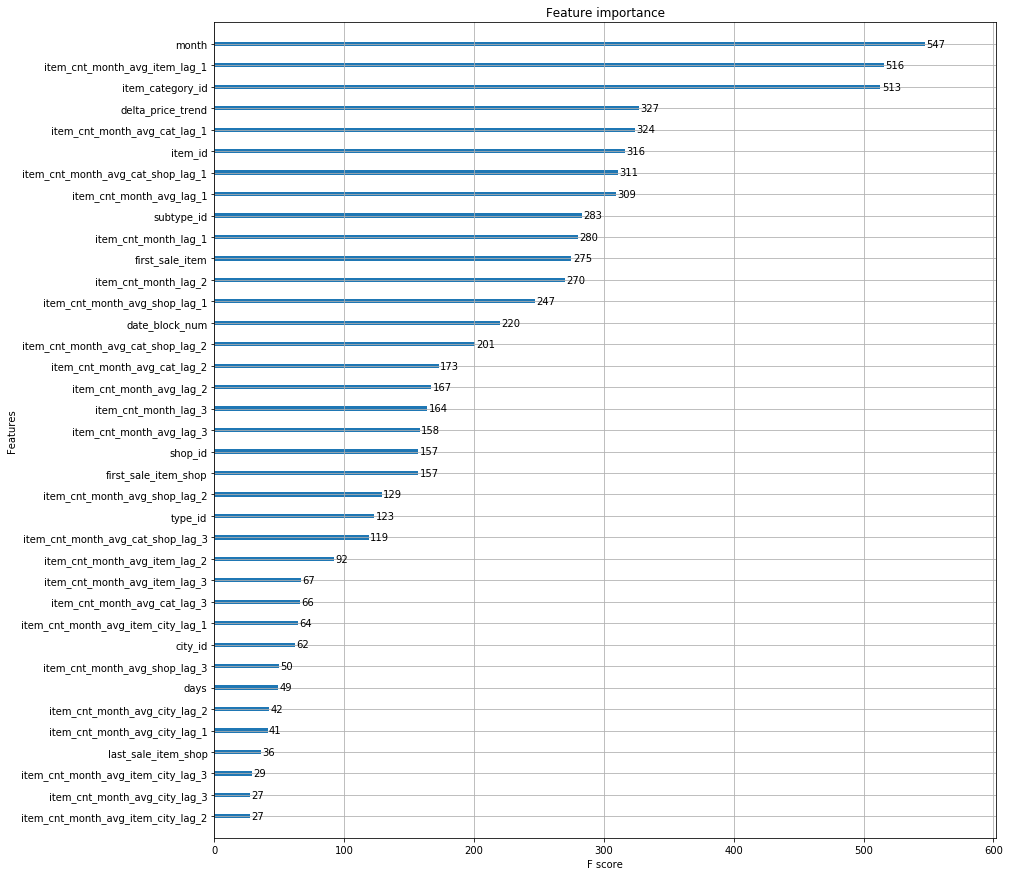

In [20]:
plt.rcParams["figure.figsize"] = (14, 15)
plot_importance(xgb_model)
plt.show()

In [0]:
xgb_validate_predict = xgb_model.predict(X_validation).clip(0, 20)

<h1>Future Prediction</h1>

In [0]:
Y_test = xgb_model.predict(X_test).clip(0, 20)

Y_test = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})

In [24]:
Y_test.head()

,ID,item_cnt_month
0,0,0.495072
1,1,0.364240
2,2,0.963230
3,3,0.432487
4,4,3.471390


In [0]:
Y_test.to_csv('xgb_Y_test.csv', index=False)